refer to: https://www.kaggle.com/solomonk/a-pytorch-nn-sgd-momentum-rmsprop-adam

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torch

### Data fields
#### train.tsv, test.tsv
The files consist of a list of product listings. These files are tab-delimited.

- `train_id` or `test_id` - the id of the listing
- `name` - the title of the listing. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]
- `item_condition_id` - the condition of the items provided by the seller 

```
1 New: New with tags (NWT), unworn, unaltered, and includes the original tags
2 Like New: New without tags (NWOT) or very lightly used with no flaws or damage
3 Good: Gently used, but still may have minor flaws such as pilling, stretching, loose threads
4 Fair: Multiple minor flaws, defects, or damage such as rips, light stains, pilling
5 Poor: Heavily used and has major cosmetic flaws or damage such as holes, strains, fading, or missing button/beads
```

- `category_name` - category of the listing
- `brand_name`
- `price` - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
- `shipping` - 1 if shipping fee is paid by seller and 0 by buyer
- `item_description` - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]


In [3]:
df_train = pd.read_csv('dataset/train.tsv', delimiter='\t')
df_test = pd.read_csv('dataset/test.tsv', delimiter='\t')

In [4]:
df_train[df_train['item_condition_id'] == 5].head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
653,653,Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36.0,0,No description yet
1027,1027,Broken necklace,5,Women/Jewelry/Necklaces,NaN,20.0,1,"10k gold 18"" chain. Broken at clasp."
2436,2436,Gameboy advance sp ags-101 FOR PARTS,5,Other/Other/Other,NaN,24.0,0,For parts . Turns on and hold battery charge ....
2803,2803,"2 Pounds Of ""Junk"" Jewelry",5,Handmade/Jewelry/Jewelry,NaN,11.0,0,"2 pounds of junk jewelry, There are some items..."


In [5]:
df_test.head() # no price column

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
print("train data shape: {} \ntest data shape: {} # no price column".format(df_train.shape, df_test.shape))

train data shape: (1482535, 8) 
test data shape: (693359, 7) # no price column


In [7]:
df_train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1.48254e+06,NaN,NaN,NaN,741267,427971,0,370634,741267,1.1119e+06,1.48253e+06
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1.48254e+06,NaN,NaN,NaN,1.90738,0.903159,1,1,2,3,5
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1.48254e+06,NaN,NaN,NaN,26.7375,38.5861,0,10,17,29,2009
shipping,1.48254e+06,NaN,NaN,NaN,0.447274,0.497212,0,0,0,1,1
item_description,1482531,1281426,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mass_product = df_train['category_name'].value_counts()[df_train['category_name'].value_counts() > 15000]

In [22]:
list(range(0, mass_product.max(), 5000))

[0,
 5000,
 10000,
 15000,
 20000,
 25000,
 30000,
 35000,
 40000,
 45000,
 50000,
 55000,
 60000]

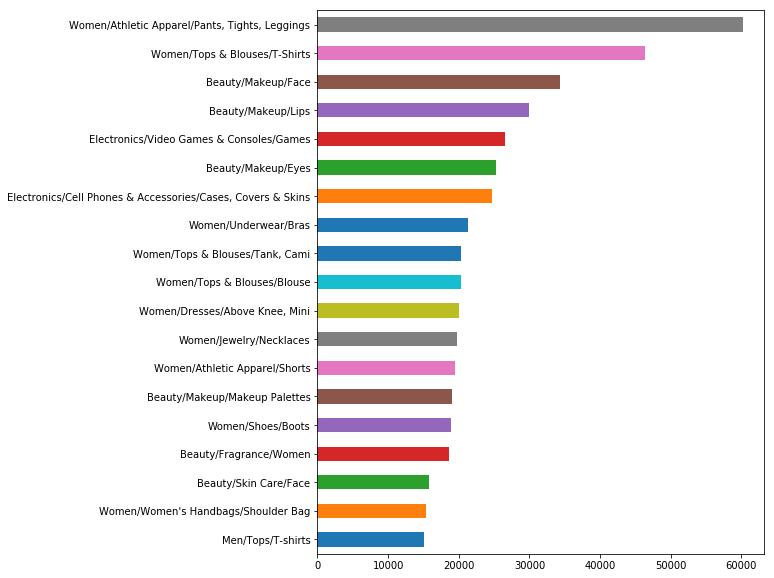

In [49]:
mass_product = mass_product.sort_values(ascending=True)
ax = mass_product.plot.barh(yticks=list(range(0, mass_product.max(), 5000)), figsize=(8,10))

### Check null data

In [10]:
df_train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [11]:
df_train[df_train.brand_name.isnull()]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...
17,17,New: Baby K'tan active baby carrier,1,Kids/Gear/Backpacks & Carriers,NaN,29.0,1,Brand new in box Size: Medium Color: Coral Ret...
23,23,Triple car charger,1,Electronics/Cell Phones & Accessories/Chargers...,NaN,8.0,1,Brand new never used All colors are available ...
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,50.0,1,No description yet
34,34,Four puppy dog stuffed animal ty,3,Kids/Toys/Stuffed Animals & Plush,NaN,5.0,1,2 beanie babies pugsley wrinkles Puppy with pu...
35,35,Black Capri Leggings w/ Flowers One size,1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,13.0,1,One size fits sizes 2-12 92% polyester 8% span...


In [12]:
df_train[df_train.category_name.isnull()]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,NaN,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,NaN,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,Michael Kors,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
1274,1274,Black Ribbed Off-the-Shoulder Crop Top,2,NaN,Urban Outfitters,15.0,0,From the silence + noise brand sold at Urban O...
1320,1320,Nice Condition Pet Escort,2,NaN,PetSafe,12.0,0,Nice condition I will wipe down before selling
1419,1419,3 Toy Bundle,1,NaN,NaN,34.0,0,"* brand new/NIB * ** price firm, no free shipp..."
1491,1491,Baby Sign,3,NaN,NaN,3.0,1,Magnetic baby sign
1521,1521,Nolan Ryan Patch Baseball Card,2,NaN,NaN,3.0,1,No description yet


### View data content

In [13]:
df_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [14]:
print(df_train['item_condition_id'].value_counts())

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [15]:
print(df_train['shipping'].value_counts())

0    819435
1    663100
Name: shipping, dtype: int64


In [16]:
print(df_train[df_train['item_description'] == 'No description yet'].shape[0])

82489
